# Описание данных
Вам представлены данные о доходах сотрудников участка горячего проката за год, в том числе данные, описывающие специфику рабочих мест. Доход состоит из оклада, премии, доплат и индивидуальных надбавок. Данных об их размерах не приводится, так как именно их Вам предстоит восстановить.
Задание
Выявите формулу дохода в целом и его составных частей Проверьте, что данная формула объясняет доход с точностью до рубля Выявите зависимости между составными частями дохода.


# Предобработка данных

In [1]:
!gdown --id 1jrO4_NWmJCp8alxooy0Q9FmzSjDtEUJG 

Downloading...
From: https://drive.google.com/uc?id=1jrO4_NWmJCp8alxooy0Q9FmzSjDtEUJG
To: /content/dulin.xlsx
100% 113k/113k [00:00<00:00, 913kB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('/content/dulin.xlsx') 

In [4]:
df.head()

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000000
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000000
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000000
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.411765
4,Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.470588


In [5]:
df.columns = ['fio', 'month', 'profession', 'rank', 'equipment', 'harmful', 'production', 'income']

In [6]:
df['month'] = df['month'].dt.month

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fio         2400 non-null   object 
 1   month       2400 non-null   int64  
 2   profession  2400 non-null   object 
 3   rank        2400 non-null   int64  
 4   equipment   2400 non-null   object 
 5   harmful     2400 non-null   int64  
 6   production  2400 non-null   int64  
 7   income      2400 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 150.1+ KB


# Анализ

Объем на металлургическом производстве один на все предприятие, а следовательно премия зависит от определенного объема. Если мы возьмем объем производства помесячно и среднюю зарплату сотрудников, мы увидим, в какой точке эта средняя зарплата начнет расти, там заканчивается оклад и начинается премия. Построим таблицу объема продукции и средней зарплаты по предприятию, отсортируем по возрастанию объем произведенной продукции. Дифференцируем эти два столбца и посчитаем стоимость одной дополнительной единицы продукции:

In [8]:
bonus = (df
           .groupby('month', as_index=False)[['production', 'income']].mean()
           .sort_values(by='production')
           .reset_index(drop=True)
           )

bonus['production_diff'] = bonus['production'].diff()
bonus['income_diff'] = bonus['income'].diff()

bonus['result'] = bonus['income_diff'] / bonus['production_diff']
bonus

,month,production,income,production_diff,income_diff,result
0,1,580.0,19885.912500,NaN,NaN,NaN
1,10,780.0,19885.912500,200.0,0.000000,0.000000
2,2,790.0,19885.912500,10.0,0.000000,0.000000
3,12,810.0,19885.912500,20.0,0.000000,0.000000
4,3,820.0,19885.912500,10.0,0.000000,0.000000
5,6,950.0,20888.536765,130.0,1002.624265,7.712494
6,11,1020.0,21590.373750,70.0,701.836985,10.026243
7,9,1080.0,22191.948309,60.0,601.574559,10.026243
8,8,1180.0,23194.572574,100.0,1002.624265,10.026243
9,4,1200.0,23395.097426,20.0,200.524853,10.026243


Средняя стоимость одной дополнительной единицы продукции равна 10.026243р, рост премии линейный. В точке с объемом 950 ед., стоимость составляет 7.712494р, так происходит потому, что цена начинает свой рост не с 820 ед., а с точки, которая нам пока неизвестна, но находящаяся в диапазоне от 820 ед. до 950 ед. То есть, рост происходит не на всем диапазоне, отсюда и значение низкое. Найдем точку начала премии. Разделим дельту стоимости в диапазоне объема от 820 ед до 950 ед на стоимость одной дополнительной единицы продукции и вычтем из 950ед:

In [9]:
950 - round(bonus.loc[5, 'income_diff'] / bonus.loc[6, 'result'], 10)

850.0

100 ед продукции, видно, что цена начинает свой рост с 850 ед. Это и есть точка, с которой начинается премия. Построим график производственного объема предприятия и константу объема, с которого начинается премия:

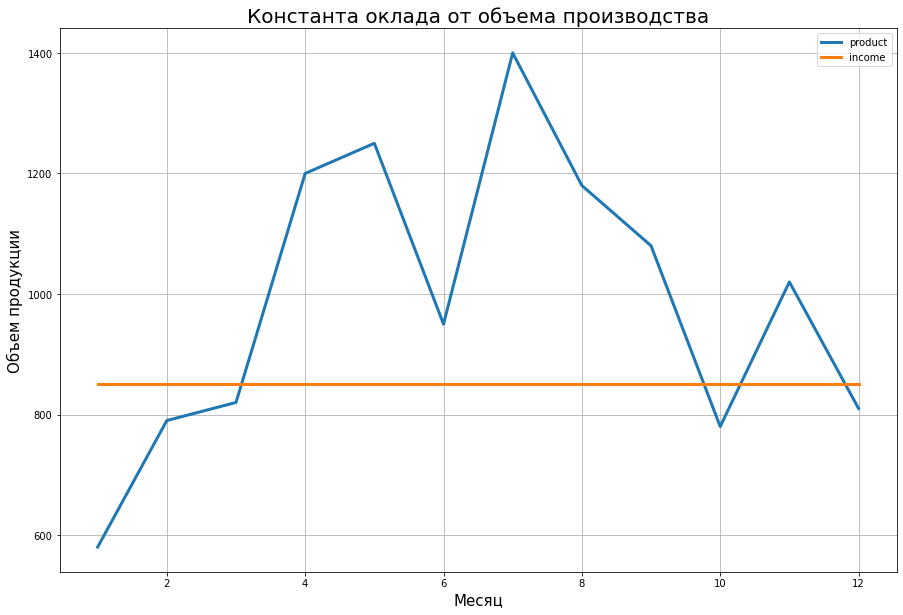

In [10]:
pd.DataFrame({
    'product': df.groupby('month')['production'].mean(),
    'income': np.linspace(850, 850, 12, dtype='int64')
}).plot(grid=True, figsize=(15, 10), linewidth=3)
plt.title("Константа оклада от объема производства", size=20)
plt.xlabel("Месяц", size=15)
plt.ylabel("Объем продукции", size=15)
plt.show()

In [11]:
df[(df['month'] == 1) & (df['profession'] == 'Огнеупорщик')]

,fio,month,profession,rank,equipment,harmful,production,income
672,Иванов П. А.,1,Огнеупорщик,4,Нагревательные печи,11,580,17523.0
1080,Куликов М. В.,1,Огнеупорщик,4,Нагревательные печи,11,580,16816.5
1896,Соколов И. А.,1,Огнеупорщик,4,Нагревательные печи,11,580,16110.0
2028,Суворов И. Р.,1,Огнеупорщик,4,Нагревательные печи,11,580,16110.0
2076,Ткачев И. Я.,1,Огнеупорщик,4,Нагревательные печи,11,580,16110.0


Видно, что при одинаковых параметрах зарплата отличается, это и есть индивидуальные надбавки. Отделим их от общей зарплаты. Возьмем минимальную зарплату по каждому месяцу, разряду и вредности. Отнимем от основной зарплаты, у основной массы должен получится нуль. 

In [12]:
n = []

for month in range(1, 13):
  for rank in df['rank'].unique():
    for harmful in df['harmful'].unique():
      n.append([month, rank, harmful, df[(df['month'] == month) & (df['rank'] == rank) & (df['harmful'] == harmful)]['income'].min()])

In [13]:
df_incom_min = pd.DataFrame(n, columns=['month', 'rank', 'harmful', 'income']).dropna().reset_index(drop=True) 

In [14]:
df = df.merge(df_incom_min, on=['month', 'rank', 'harmful'])
df.columns = ['fio', 'month', 'profession', 'rank', 'equipment', 'harmful', 'production', 'income_brutto', 'income_netto']

In [15]:
df['bonus'] = df['income_brutto'] - df['income_netto']

In [16]:
df.head()

,fio,month,profession,rank,equipment,harmful,production,income_brutto,income_netto,bonus
0,Абрамов Е. Д.,1,Уборщик,3,Пилигримовые станы,18,580,16638.0,15420.0,1218.0
1,Абрамов Ф. М.,1,Уборщик,3,Пилигримовые станы,18,580,16029.0,15420.0,609.0
2,Александров А. М.,1,Уборщик,3,Пилигримовые станы,18,580,15420.0,15420.0,0.0
3,Быков Л. Н.,1,Подручный вальцовщика,3,Пилигримовые станы,18,580,15420.0,15420.0,0.0
4,Волков Д. М.,1,Подручный вальцовщика,3,Пилигримовые станы,18,580,16638.0,15420.0,1218.0


In [17]:
df[df['bonus'] == 0]['bonus'].count()

1200

In [18]:
df[df['bonus'] != 0]['bonus'].count()

1200

Надбавки есть у половины работников. Посмотрим на данные без нулей.

In [19]:
df[(df['bonus'] != 0) & (df['profession'] == 'Уборщик') & (df['month'] == 1)].head(10)

,fio,month,profession,rank,equipment,harmful,production,income_brutto,income_netto,bonus
0,Абрамов Е. Д.,1,Уборщик,3,Пилигримовые станы,18,580,16638.0,15420.0,1218.0
1,Абрамов Ф. М.,1,Уборщик,3,Пилигримовые станы,18,580,16029.0,15420.0,609.0
15,Павловский Д. А.,1,Уборщик,3,Пилигримовые станы,18,580,16029.0,15420.0,609.0
2235,Кондратьев Д. Д.,1,Уборщик,3,Вспомогательные помещения,0,580,12789.0,12180.0,609.0
2238,Степанов А. М.,1,Уборщик,3,Вспомогательные помещения,0,580,12789.0,12180.0,609.0
2239,Федотов М. М.,1,Уборщик,3,Вспомогательные помещения,0,580,13398.0,12180.0,1218.0


In [20]:
df[(df['bonus'] != 0) & (df['profession'] == 'Огнеупорщик') & (df['month'] == 1)].head()

,fio,month,profession,rank,equipment,harmful,production,income_brutto,income_netto,bonus
2340,Иванов П. А.,1,Огнеупорщик,4,Нагревательные печи,11,580,17523.0,16110.0,1413.0
2341,Куликов М. В.,1,Огнеупорщик,4,Нагревательные печи,11,580,16816.5,16110.0,706.5


Из вывода видно, что для каждой професии бывают надбавки двух видов: первый вариант и второй в два раза больше. Также с ростом производства растет индивидуальная надбавка. Если бы это был хвост нелинейности он присутствовал бы у всех, а у нас в половине случаев нули. 

Определим стоимость одной единицы вредности. Есть две должности уборщика: одна с вредностью, другая без нее.
Вычтем из зп с вредностью зп без вредности и разделим на коэффициент вредности.


In [21]:
df[df['harmful'] == 0]['profession'].unique()

array(['Контролер качества готовой продукции', 'Уборщик'], dtype=object)

In [22]:
df[(df['profession'] == 'Уборщик') & (df['equipment'] == 'Пилигримовые станы') & (df['month'] == 1)].head()

,fio,month,profession,rank,equipment,harmful,production,income_brutto,income_netto,bonus
0,Абрамов Е. Д.,1,Уборщик,3,Пилигримовые станы,18,580,16638.0,15420.0,1218.0
1,Абрамов Ф. М.,1,Уборщик,3,Пилигримовые станы,18,580,16029.0,15420.0,609.0
2,Александров А. М.,1,Уборщик,3,Пилигримовые станы,18,580,15420.0,15420.0,0.0
6,Воронов Р. И.,1,Уборщик,3,Пилигримовые станы,18,580,15420.0,15420.0,0.0
10,Комаров А. И.,1,Уборщик,3,Пилигримовые станы,18,580,15420.0,15420.0,0.0


In [23]:
df[(df['profession'] == 'Уборщик') & (df['equipment'] == 'Вспомогательные помещения') & (df['month'] == 1)].head()

,fio,month,profession,rank,equipment,harmful,production,income_brutto,income_netto,bonus
2232,Григорьев А. Т.,1,Уборщик,3,Вспомогательные помещения,0,580,12180.0,12180.0,0.0
2233,Журавлев Б. И.,1,Уборщик,3,Вспомогательные помещения,0,580,12180.0,12180.0,0.0
2234,Клюев Д. М.,1,Уборщик,3,Вспомогательные помещения,0,580,12180.0,12180.0,0.0
2235,Кондратьев Д. Д.,1,Уборщик,3,Вспомогательные помещения,0,580,12789.0,12180.0,609.0
2236,Львов А. С.,1,Уборщик,3,Вспомогательные помещения,0,580,12180.0,12180.0,0.0


In [24]:
(15420.0	- 12180.0) / 18 

180.0

Одна единица вредности равна 180р. Создадим новый столбец с базовой зарплатой и вычтем из него произведение стоимости вредности и коэффициента вредности. 

In [25]:
basic_salary = df[df['month'] == 1][['fio', 'income_netto']]

In [26]:
df = df.merge(basic_salary, on=['fio'])

In [27]:
df.columns = ['fio', 'month', 'profession', 'rank', 'equipment', 'harmful', 'production', 'income_brutto', 'income_netto', 'bonus', 'basic_salary']

In [28]:
df['basic_salary'] = df['basic_salary'] - df['harmful'] * 180

In [29]:
df[df['bonus'] != 0].sample(10)

,fio,month,profession,rank,equipment,harmful,production,income_brutto,income_netto,bonus,basic_salary
480,Семенов Д. А.,1,Вальцовщик,6,Пилигримовые станы,18,580,23211.000000,22260.000000,951.000000,19020.0
1398,Лебедев Л. Е.,7,Вальцовщик,7,Пилигримовые станы,18,1400,33896.911765,32437.058824,1459.852941,22060.0
601,Косарев А. М.,2,Нагревальщик металла,7,Нагревательные печи,22,790,27123.000000,26020.000000,1103.000000,22060.0
1328,Верещагин Я. А.,9,Вальцовщик,7,Прошивной стан,18,1080,29536.817647,28284.588235,1252.229412,22060.0
2084,Захаров К. Д.,9,Посадчик металла,4,Нагревательные печи,22,1080,21605.876471,20001.705882,1604.170588,14130.0
2129,Куликов А. Л.,6,Посадчик металла,4,Нагревательные печи,22,950,20417.294118,18921.176471,1496.117647,14130.0
2313,Степанов А. М.,10,Уборщик,3,Вспомогательные помещения,0,780,12789.000000,12180.000000,609.000000,12180.0
1705,Яковлев Д. И.,2,Подручный вальцовщика,4,Прошивной стан,18,790,18783.000000,17370.000000,1413.000000,14130.0
2155,Михайлов М. М.,8,Нагревальщик металла,4,Нагревательные печи,22,1180,22520.170588,20832.882353,1687.288235,14130.0
1308,Богданов А. Т.,1,Вальцовщик,7,Прошивной стан,18,580,26403.000000,25300.000000,1103.000000,22060.0


В столбце бонус изменим значения на базовые значения, в которых нет премии.

In [30]:
basic_bonus = df[df['month'] == 1][['fio', 'bonus']]

In [31]:
df = df.merge(basic_bonus, on=['fio'])

In [32]:
df.columns = ['fio', 'month', 'profession', 'rank', 'equipment', 'harmful', 
                     'production', 'income_brutto', 'income_netto', 'bonus', 'basic_salary', 'basic_bonus']

In [33]:
df = df.drop('bonus', axis=1)

In [34]:
df[df['basic_bonus'] != 0].sample(10)

,fio,month,profession,rank,equipment,harmful,production,income_brutto,income_netto,basic_salary,basic_bonus
860,Русанов Т. И.,9,Нагревальщик металла,5,"Нагревательные печи, нагрев",22,1080,23497.844118,22567.470588,16390.0,819.5
516,Соловьев И. М.,1,Вальцовщик,6,Прошивной стан,18,580,24162.000000,22260.000000,19020.0,1902.0
1259,Марков И. П.,12,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,810,23163.000000,22060.000000,22060.0,1103.0
1828,Комаров Л. Ф.,5,Нагревальщик металла,6,Нагревательные печи,22,1250,28630.058824,27455.294118,19020.0,951.0
214,Прохоров М. Р.,11,Подручный вальцовщика,3,Пилигримовые станы,18,1020,17307.900000,16638.000000,12180.0,609.0
1291,Филиппов И. П.,8,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1180,28976.458824,26342.235294,22060.0,2206.0
1708,Яковлев Д. И.,5,Подручный вальцовщика,4,Прошивной стан,18,1250,22440.176471,20694.705882,14130.0,1413.0
886,Филатов К. Т.,11,Нагревальщик металла,5,"Нагревательные печи, нагрев",22,1020,23791.900000,21989.000000,16390.0,1639.0
96,Жаров С. Д.,1,Подручный вальцовщика,3,Пилигримовые станы,18,580,16638.000000,15420.000000,12180.0,1218.0
1537,Беляков К. М.,2,Подручный вальцовщика,4,Прошивной стан,18,790,18783.000000,17370.000000,14130.0,1413.0


Из вывода видно, что базовая премия составляет 5 и 10 процентов от базовой зарплаты, создадим новый столбец со значениями 0, 0.05 и 0.1 соответственно.

In [35]:
bonus_min = [round(df[(df['rank'] == i) & (df['basic_bonus'] != 0)]['basic_bonus'].min()) for i in range(3, 8)]

In [36]:
bonus_max = [round(df[(df['rank'] == i) & (df['basic_bonus'] != 0)]['basic_bonus'].max()) for i in range(3, 8)]

In [37]:
df['precent'] = np.nan

In [38]:
df[round(df['basic_bonus']).isin(bonus_min)] = df.fillna(.05) 

In [39]:
df[round(df['basic_bonus']).isin(bonus_max)] = df.fillna(.1) 

In [40]:
df[df['basic_bonus'] == 0] = df.fillna(0) 

In [41]:
df[df['month'] == 1].head()

,fio,month,profession,rank,equipment,harmful,production,income_brutto,income_netto,basic_salary,basic_bonus,precent
0,Абрамов Е. Д.,1,Уборщик,3,Пилигримовые станы,18,580,16638.0,15420.0,12180.0,1218.0,0.10
12,Абрамов Ф. М.,1,Уборщик,3,Пилигримовые станы,18,580,16029.0,15420.0,12180.0,609.0,0.05
24,Александров А. М.,1,Уборщик,3,Пилигримовые станы,18,580,15420.0,15420.0,12180.0,0.0,0.00
36,Быков Л. Н.,1,Подручный вальцовщика,3,Пилигримовые станы,18,580,15420.0,15420.0,12180.0,0.0,0.00
48,Волков Д. М.,1,Подручный вальцовщика,3,Пилигримовые станы,18,580,16638.0,15420.0,12180.0,1218.0,0.10


Далее, для оклада netto посчитаем стоимость одной дополнительной единицы продукции для каждой профессии с учетом разряда и сохраним в отдельном столбце:

In [42]:
n = []
 
for rank in df['rank'].unique():
    bonus = (df[(df['rank'] == rank) & (df['basic_bonus'] == 0)]
            .groupby('month', as_index=False)[['production', 'income_netto']].mean()
            .sort_values(by='production')
            .reset_index(drop=True)
            )

    bonus['production_diff'] = bonus['production'].diff()
    bonus['income_diff'] = bonus['income_netto'].diff()

    bonus['result'] = bonus['income_diff'] / bonus['production_diff']
    n.append([rank, bonus.loc[7, 'result']])

In [43]:
df = df.merge(pd.DataFrame(n, columns=['rank', 'coff']), on='rank')

Удалим столбец income_netto, он нам больше не нужен.

In [44]:
df = df.drop('income_netto', axis=1)

Напишем функцию расчета зарплаты и посчитаем зарплату по формуле, и сравним с исходной.

[Дополнительный объем] * [коффициент доп/ед] + [вредность] * [180] + [Оклад] * [Дополнительный объем] * [коффициент доп/ед] * [%]




In [45]:
def result(row):
  production = row['production']
  coff = row['coff']
  harmful = row['harmful']
  basic_salary = row['basic_salary']
  bonus = row['basic_bonus']
  precent = row['precent']
  
  if production > 850: 
    production -= 850
    production *= coff
  else:
    production = 0
    
  return round(production + harmful * 180 + basic_salary + bonus + production * precent)

In [46]:
df['income_brutto'] = round(df['income_brutto'])

In [47]:
df['result'] = df.apply(result, axis=1) 

In [48]:
df.sample(10)

,fio,month,profession,rank,equipment,harmful,production,income_brutto,basic_salary,basic_bonus,precent,coff,result
1787,Громов Л. Я.,12,Подручный вальцовщика,4,Прошивной стан,18,810,18076.0,14130.0,706.5,0.05,8.311765,18076
2210,Ильинский Н. Д.,3,Посадчик металла,4,Нагревательные печи,22,820,18090.0,14130.0,0.0,0.00,8.311765,18090
2066,Носов М. Д.,3,Оператор поста управления,4,Калибровочный стан,8,820,16276.0,14130.0,706.5,0.05,8.311765,16276
2069,Носов М. Д.,6,Оператор поста управления,4,Калибровочный стан,8,950,17149.0,14130.0,706.5,0.05,8.311765,17149
2235,Куликов А. Л.,4,Посадчик металла,4,Нагревательные печи,22,1200,22703.0,14130.0,1413.0,0.10,8.311765,22703
709,Комаров Л. Ф.,2,Нагревальщик металла,6,Нагревательные печи,22,790,23931.0,19020.0,951.0,0.05,11.188235,23931
140,Краснов И. М.,9,Уборщик,3,Пилигримовые станы,18,1080,17068.0,12180.0,0.0,0.00,7.164706,17068
1148,Окулов Л. Н.,9,Вальцовщик,7,Пилигримовые станы,18,1080,30789.0,22060.0,2206.0,0.10,12.976471,30789
951,Лазарев А. Н.,4,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1200,27932.0,22060.0,1103.0,0.05,12.976471,27932
739,Соколов С. Д.,8,Нагревальщик металла,6,Нагревательные печи,22,1180,26672.0,19020.0,0.0,0.00,11.188235,26672


In [49]:
(df['income_brutto'] == df['result']).mean() 

1.0

Исходная зарплата совпадает с зарплатой расчитанной по формуле на 100%

# Вывод

In [50]:
df[df['month'] == 1][['profession', 'rank', 'basic_salary', 'coff', 'basic_bonus']].drop_duplicates().sort_values(by='rank').reset_index(drop=True)

,profession,rank,basic_salary,coff,basic_bonus
0,Уборщик,3,12180.0,7.164706,1218.0
1,Уборщик,3,12180.0,7.164706,609.0
2,Уборщик,3,12180.0,7.164706,0.0
3,Подручный вальцовщика,3,12180.0,7.164706,0.0
4,Подручный вальцовщика,3,12180.0,7.164706,1218.0
5,Подручный вальцовщика,3,12180.0,7.164706,609.0
6,Подручный вальцовщика,4,14130.0,8.311765,1413.0
7,Подручный вальцовщика,4,14130.0,8.311765,706.5
8,Резчик горячего металла,4,14130.0,8.311765,706.5
9,Резчик горячего металла,4,14130.0,8.311765,0.0


Зарплата работников складывается из оклада в зависимости от разряда, у всех профессий, без учета разряда, одна и таже зарплата, плюс доплата за вредность 180р за единицу вредности, оборудование на котором работает сотрудник на зарплату не влияет. Также, если объем производства в месяц превышает 850ед. за каждую дополнительную единицу начисляется доплата в зависимости от разряда. Нелинейность здесь исключена потому, что исключая индивидуальные надбавки рост линейный, а надбавки есть не у всех. Я думаю, что надбавка не начисляется отдельно, а является постоянной, фиксированной. Например, за выслугу лет прибавляется к зарплате однократно и является ее неотемлемой частью, поэтому на нее тоже начисляется премия за дополнительный объем производства. В таблице выше представлены уникальные профессии с разрядом, коэффициентом, окладом, а также индивидуальной премией за дополнительную единицу продукции.

Формула:

[Дополнительный объем] * [коффициент доп/ед] + [вредность] * [180] + [Оклад] * [Дополнительный объем] * [коффициент доп/ед] * [%]